## Exploring the dataset

In [ ]:
import numpy as np
from zipfile import ZipFile
import h5py
import matplotlib.pyplot as plt
import cv2
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import csv
import pandas as pd

In [ ]:
with ZipFile('MNIST_synthetic.zip', 'r') as zipObj:
  zipObj.extractall()

In [ ]:
hf = h5py.File('MNIST_synthetic.h5', 'r')
hf.keys()

<KeysViewHDF5 ['test_dataset', 'train_dataset', 'train_labels']>

(56000, 4096)


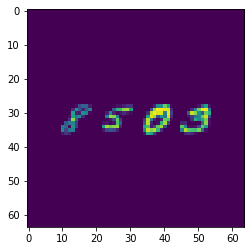

In [ ]:
test_data = hf.get('test_dataset')
train_data = hf.get('train_dataset')
train_labels = hf.get('train_labels')

## np.squeeze removes all elements of the dataset that are 1-dimensional 
test_data = np.squeeze(np.asarray(test_data))
train_data = np.squeeze(np.asarray(train_data))
train_labels = np.squeeze(np.asarray(train_labels))

#Normalize the data
#train_data = train_data / 255
#test_data = test_data / 255

## flattening each row into a 1D array of length 4096 
flattened_train = []
for i in train_data:
  flattened_train.append(np.reshape(i, -1))

flattened_train = np.asarray(flattened_train)
print(flattened_train.shape)
plt.imshow(np.reshape(flattened_train[0], (64,64)))

(56000, 64, 64)
(56000, 5)
[ 8  5  0  3 10]


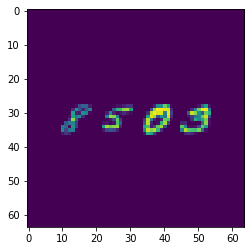

In [ ]:
print(train_data.shape)
print(train_labels.shape)
print(train_labels[0])
plt.imshow(train_data[0])

#Image Segmentation

##This is a practice example showing how we could segment the image and reassign the labels. We can make this into a general function

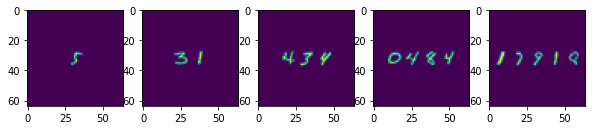

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,5,1)
plt.imshow(train_data[9])

plt.subplot(1,5,2)
plt.imshow(train_data[26])

plt.subplot(1,5,3)
plt.imshow(train_data[5])

plt.subplot(1,5,4)
plt.imshow(train_data[7])

plt.subplot(1,5,5)
plt.imshow(train_data[2])

plt.show()

##Hardcoded Method
The hardcoded method can be used when you have labels with your data as the labels are used to determine the number of cuts to make. This works because all images with the same number of digits have the digits in the same locations. So all 3 digit photos have the 3 digits in the same spot, etc. 

[1, 7, 9, 1, 8]


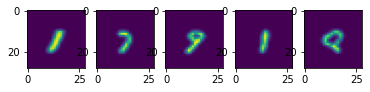

In [ ]:
#Better image splitter that does not rely on contours... less processing-- need a label tho so only for training
def imageSegment(images, labels):
  labelCount = 0
  for l in labels:
    if l != 10: labelCount += 1

  segmentedImages = []
  testLabels = []

  if labelCount == 1:
    segmentedImages.append(cv2.resize(images[24:39, 24:39], (18,18)))

  if labelCount == 2:
    segmentedImages.append(cv2.resize(images[24:39, 19:32], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 33:45], (18,18)))

  if labelCount == 3:
    segmentedImages.append(cv2.resize(images[24:39, 15:25], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 25:38], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 38:51], (18,18)))

  if labelCount == 4:
    segmentedImages.append(cv2.resize(images[24:39, 8:20], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 20:32], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 32:44], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 44:56], (18,18)))

  if labelCount == 5:
    segmentedImages.append(cv2.resize(images[24:39, 2:14], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 14:26], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 26:38], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 38:50], (18,18)))
    segmentedImages.append(cv2.resize(images[24:39, 50:62], (18,18)))

  #Put the labels back in order
  for j in range(labelCount):
    testLabels.append(labels[j])

  #Padding to make the image format closer to the test method where we have to use contours
  for j in range(len(segmentedImages)):
    segmentedImages[j] = np.pad(segmentedImages[j], ((5,5),(5,5)), "constant", constant_values = 0)

  return segmentedImages, testLabels
  
testImage, testLabels = imageSegment(train_data[2], train_labels[2])
print(testLabels)
plt.subplot(1,5,1)
plt.imshow(testImage[0])
plt.subplot(1,5,2)
plt.imshow(testImage[1])
plt.subplot(1,5,3)
plt.imshow(testImage[2])
plt.subplot(1,5,4)
plt.imshow(testImage[3])
plt.subplot(1,5,5)
plt.imshow(testImage[4])
plt.show()

##CV2 Contour Method
The contour method can be used when you do NOT have labels with your data. This splits using the cv2 contour function to determine zones where digits might be likely in the image. Unfortunately it doesn't work super well and the cuts are not always good cuts. There is some error checking, but this is only applicable if you plan on training with this data. When you are training, if the sign is positive it means that we detected a potentially invalid number of cuts. So we have the option of discarding that photo from the training set as the labels might not match the digit OR images may not even be of the digits but rather a corner of a digit or something. 

In [ ]:
#Used on the test data where we have no labels
#A general function to segment the images
#Takes in one original image (with up to 5 digits) with the corresponding label 
#Return a number of images equal to the number of digits with new corresponding labels for each image

def imageSegmentTest(images, labels):
  #Because the image passed in is a numpy array and we want to work with a cv2 image, we write and read it
  #If we can think of a better way to convert the numpy array to a cv2 image that would work better
  cv2.imwrite('test_image.jpg', images)
  images = cv2.imread('test_image.jpg')
  gray_image = cv2.cvtColor(images.copy(), cv2.COLOR_BGR2GRAY)
  #blur = cv2.GaussianBlur(gray_image, (3,3), 0)
  ret, thresh = cv2.threshold(gray_image.copy(), 75, 255, cv2.THRESH_BINARY)
  tempContours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  x_pos = []
  preprocessed_digits = []

  #Check that the number of counters is not > 5. We only have 5 digits at most so if we have
  #more than 5 counters there was an error
  #We also count the number of non10 digits in the label
  count = 0
  for i in range(5):
    if labels[i] != 10: count += 1

  contours = []
  for i in range(len(tempContours)):
    if cv2.contourArea(tempContours[i]) != 0: contours.append(tempContours[i])
    #print(cv2.contourArea(tempContours[i]))

  if len(contours) == 0: contours = tempContours

  sign = False

  length = len(contours)
  if length > 5: 
    length = 5
    sign = True

  if length != count: sign = True


  for i in range(length):
    x,y,w,h = cv2.boundingRect(contours[i])

    #Crop the digit corresponding the current countour
    digit = thresh[y-2:y+h+2, x-2:x+w+2]

    #Resize the digit to 18,18
    # Christina changed this code 
    resized_digit = cv2.resize(digit, (28,28))

    # #Add Padding to make digit size 28,28
    # padded_digit = np.pad(resized_digit, ((5,5),(5,5)), "constant", constant_values = 0)

    #Add the new digit to the preprocessed digit array
    #preprocessed_digits.append(padded_digit)
    preprocessed_digits.append(resized_digit)

    #Save x position to organize array later
    x_pos.append(x)
  

  #Given the x_positions sort the labels
  new_labels = [0]*length

  #Find the min_index(leftmost digit), update label, repeat
  for i in range(length):
    index = np.argmin(x_pos)
    new_labels[index] = labels[i]
    #Set the updated position to 65 so we dont repeat this digit (image size is 64x64)
    x_pos[index] = 65

  return (preprocessed_digits, new_labels, sign)

#Initial Image Pre-Processing




## Hardcoded image segment for train data
Cuts all the digits out of every photo and combines it into one long array. Labels get changed to 1 label per image since we now only have 1 digit per image. Only good for training.

In [ ]:
#We will combine the inputs/labels of the entire dataset
#We will first segment the images then create a new dataset with the individual images
trainer_set_images = []
trainer_set_labels = []

#Start combining train_data and train_labels
for i in range(len(train_data)):
  temp_images, temp_labels = imageSegment(train_data[i], train_labels[i])
  #We use extend instead of append so we append each individual item rather than the total sets
  trainer_set_images.extend(temp_images)
  trainer_set_labels.extend(temp_labels)

print("We have "+str(len(trainer_set_images))+" images, and "+str(len(trainer_set_labels))+" labels. There were "+str(len(train_data))+" original image sets.")

We have 167886 images, and 167886 labels. There were 56000 original image sets.


##CV2 Contour Method for test data
Cuts all the digits out of every photo and combines it into one long array. Labels get changed to 1 label per image since we now only have 1 digit per image. Good for training and testing but not as reliable as the hardcoded method. 

In [ ]:
#We will combine the inputs/labels of the entire dataset
#We will first segment the images then create a new dataset with the individual images
trainer_set_images = []
trainer_set_labels = []
count = 0
errorImages = []
errorLabels = []
errorIndex = []

#Start combining train_data and train_labels
for i in range(len(train_data)):
  temp_images, temp_labels, sign = imageSegmentTest(train_data[i], train_labels[i])
  if sign == True: 
    count += 1
    errorImages.extend(temp_images)
    errorLabels.extend(temp_labels)
    errorIndex.append(i)
  else:
    #We use extend instead of append so we append each individual item rather than the total sets
    trainer_set_images.extend(temp_images)
    trainer_set_labels.extend(temp_labels)

print("We have "+str(len(trainer_set_images))+" images, and "+str(len(trainer_set_labels))+" labels. There were "+str(count)+" bad contours out of "+str(len(train_data))+" original image sets.")

We have 159851 images, and 159851 labels. There were 2159 bad contours out of 56000 original image sets.


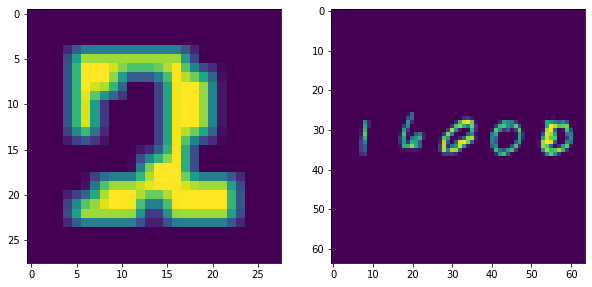

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(errorImages[9])

plt.subplot(1,2,2)
plt.imshow(train_data[errorIndex[1]])

plt.show()

temp_images, temp_labels, sign = imageSegmentTest(train_data[errorIndex[1]], train_labels[errorIndex[1]])

5


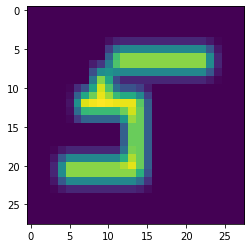

In [ ]:
plt.imshow(trainer_set_images[0])
print(trainer_set_labels[0])

#PreProcessing


In [ ]:
def crossValidationFold(data, target):
  size = len(data)
  fold_size = int(size/5)

  #Create folds by splitting datset evenly. The return will be a tuple of (data, target)
  fold1 = data[0:fold_size], target[0:fold_size]
  fold2 = data[(fold_size+1):(fold_size*2)], target[(fold_size+1):(fold_size*2)]
  fold3 = data[(fold_size*2 + 1):(fold_size*3)], target[(fold_size*2 + 1):(fold_size*3)]
  fold4 = data[(fold_size*3 + 1):(fold_size*4)], target[(fold_size*3 + 1):(fold_size*4)]
  fold5 = data[(fold_size*4 + 1): size], target[(fold_size*4 + 1): size]
  
  return [fold1, fold2, fold3, fold4, fold5]

In [ ]:
#Will create our batches
def batch_creator(data, batch_size, batch_num):
  temp_images, temp_labels = data

  start_index = batch_num*batch_size
  end_index = start_index+batch_size

  if end_index > len(temp_images)-1: end_index = len(temp_images)-1

  return ((torch.as_tensor(temp_images[start_index:end_index])).unsqueeze(1), torch.as_tensor(temp_labels[start_index:end_index]))

The cell below combines the data produced by the segmentation functions into a single combined image and label array. You need to rerun this everytime you resegment the original data.

In [ ]:
#Lets set up our data first
trainingData = []
trainingLabels = []
validationData = []
validationLabels = []

#Shuffle the dataset
trainer_set_images, trainer_set_labels = shuffle(trainer_set_images, trainer_set_labels)

#Will produce 5 folds
dataFolds = crossValidationFold(trainer_set_images, trainer_set_labels)

#Integer 0-4 which sets which fold will be validation fold. Our data is shuffled
#so this does not affect randomness of data
validationFold = 2
validationData, validationLabels = dataFolds[validationFold]

for j in range(5):
  if validationFold != j:
    tempData, tempTarget = dataFolds[j]

    trainingData.extend(tempData)
    trainingLabels.extend(tempTarget)

trainer_set = (trainingData, trainingLabels)
valid_set = (validationData, validationLabels)

#Neural Network

In [ ]:
#This cell handles the training
class Net(nn.Module):
  def __init__(self):
    #we can try this architecture from this article: https://towardsdatascience.com/mnist-handwritten-digits-classification-using-a-convolutional-neural-network-cnn-af5fafbc35e9
    super(Net,self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
    self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
    self.linear_1 = nn.Linear(7*7*64, 128)
    self.linear_2 = nn.Linear(128, 11)
    self.dropout = nn.Dropout(p=0.5)
    self.relu = nn.ReLU()

    # super(Net,self).__init__()
    # self.conv1 = nn.Conv2d(1, 32, 3)
    # self.conv2 = nn.Conv2d(32, 64, 3)
    # self.conv3 = nn.Conv2d(64, 64, 3)
    # self.conv4 = nn.Conv2d(64, 64, 3)
    # self.fc1 = nn.Linear(4096, 11)

  def forward(self, x):
    x = self.conv1(x)
    x = self.relu(x)
    x = self.max_pool2d(x)
    x = self.conv2(x)
    x = self.relu(x)
    x = self.max_pool2d(x)
    x = x.reshape(x.size(0), -1)
    x = self.linear_1(x)
    x = self.relu(x)
    x = self.dropout(x)
    pred = self.linear_2(x)

    return pred

    # x = F.relu(self.conv1(x))
    # x = F.relu(self.conv2(x))
    # x = F.max_pool2d(x, (2,2))
    # x = F.relu(self.conv3(x))
    # x = F.relu(self.conv4(x))
    # x = torch.flatten(x, 1, 3)
    # x = self.fc1(x)
    # return x

net = Net()

#Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr = 0.001)

# batch_size = 32
# #Given batch_size determine number of iterations
# iterations = (int)((len(trainer_set[0]))/batch_size)

# #Train the network now for 10 epoch
# for epoch in range(10):

#   running_loss = 0.0
#   for i in range(iterations):
#     inputs, labels = batch_creator(trainer_set, batch_size, batch_num=i)

#     inputs = inputs.float()
#     labels = labels.long()

#     inputs = inputs.to(device)
#     labels = labels.to(device)

#     optimizer.zero_grad()

#     outputs = net(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()
#     optimizer.step()

#     running_loss += loss.item()
#     if i % 1000 == 999:    # print every 1000 mini-batches
#       print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
#       running_loss = 0.0

# print('Finished Training')

# #Save the model
# torch.save(net.state_dict(), './neural_net.pth')

In [ ]:
#Lets see how well we did
# correct = 0
# total = 0
# batch_size = 32
# iterations = (int)((len(valid_set[0]))/batch_size)

# with torch.no_grad():
#   net.eval()
#   for i in range(iterations):
#     inputs, labels = batch_creator(valid_set, batch_size, batch_num=i)

#     inputs = inputs.float()
#     labels = labels.long()
    
#     labels = labels.to(device)
#     inputs = inputs.to(device)

#     outputs = net(inputs)
#     _, predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()

# print(correct)
# print(total)
# print('Accuracy of the network on the test images: %d %%' % (100 * correct/total))

33189
33568
Accuracy of the network on the test images: 98 %


#New training method: one train-validation split 

CHECK MY NOTE ABOUT ROUNDING DOWN NUM ITERATIONS AND POTENTIALLY MISSING OUT ON A TRAINING BATCH 

In [ ]:
#from above code splitting the data into trainer_set and validation_set, i can see that the training and validation data will be passed as a tuple of (samples, labels)
def train(model, optimizer, trainer_set, validation_set, save_file_name, batch_size=128, max_epochs_stop = 5, num_epochs=30, print_every=2):
  # Early stopping intialization
  epochs_no_improve = 0
  min_valid_loss = np.Inf
  max_valid_acc = 0
  best_epoch = 0
  history = []

  criterion = nn.CrossEntropyLoss()

  for epoch in range(num_epochs):

    # keeping track of training and validation loss and accuracy for each epoch to be added in history array 
    running_train_loss = 0.0
    running_valid_loss = 0.0

    running_train_acc = 0.0
    running_valid_acc = 0.0

    # Make sure to set model to training mode
    model.train()

    #Given batch_size determine number of iterations
    iterations = (int)((len(trainer_set[0]))/batch_size) ## doesnt this round down? so if num iterations is 538.7 it will be 538, when really it should be 539 for the last batch of smaller size to go thru 
    
    for i in range(iterations):
      
      # getting the training inputs and labels from the current batch
      inputs, labels = batch_creator(trainer_set, batch_size, batch_num=i)

      # getting them into the right datatypes
      inputs = inputs.float()
      labels = labels.long()

      # getting them onto GPU 
      inputs = inputs.to(device)
      labels = labels.to(device)

      # clear gradients
      optimizer.zero_grad()

      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_train_loss += loss.item() 

      _, predicted = torch.max(outputs.data, 1)
      # inputs.shape[0] is the batch size
      running_train_acc += (predicted == labels).sum().item()

    # training for this epoch has ended, time to start validation for this epoch 
    with torch.no_grad():
      # Set to evaluation mode
      model.eval()

      # Validation loop
      iterations = (int)((len(validation_set[0]))/batch_size) ## doesnt this round down? so if num iterations is 538.7 it will be 538, when really it should be 539 for the last batch of smaller size to go thru 
      for i in range(iterations):
        inputs, labels = batch_creator(validation_set, batch_size, batch_num=i)

        # getting them into the right datatypes
        inputs = inputs.float()
        labels = labels.long()
    
        # getting them onto GPU 
        labels = labels.to(device)
        inputs = inputs.to(device)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        running_valid_loss += loss.item()
        running_valid_acc += (predicted == labels).sum().item()

    # Calculating Average Losses
    running_train_loss = running_train_loss/len(trainer_set[0])
    running_valid_loss = running_valid_loss/len(validation_set[0])

    # Calculating Average Accuracies
    running_train_acc = running_train_acc/len(trainer_set[0])
    running_valid_acc = running_valid_acc/len(validation_set[0])

    history.append([running_train_loss, running_valid_loss, running_train_acc, running_valid_acc])

    # Print training and validation results
    if (epoch + 1) % print_every == 0:
      print(f'\nEpoch: {epoch} \tTraining Loss: {running_train_loss:.8f} \tValidation Loss: {running_valid_loss:.8f}')
      print(f'\t\tTraining Accuracy: {100 * running_train_acc:.2f}%\t Validation Accuracy: {100 * running_valid_acc:.2f}%')

    # Save the model if validation loss in this epoch decreases
    if running_valid_loss < min_valid_loss:
      # Save the model
      print("..... Saving model .....")
      torch.save(model.state_dict(), save_file_name)
      # Track improvement
      epochs_no_improve = 0
      min_valid_loss = running_valid_loss
      max_valid_acc = running_valid_acc
      best_epoch = epoch
    # Otherwise increment count of epochs with no improvement in loss
    else:
      epochs_no_improve += 1
      # Trigger early stopping
      if epochs_no_improve >= max_epochs_stop:
        print(f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {min_valid_loss:.2f} and acc: {100 * max_valid_acc:.2f}%')
        # load the best state dict
        model.load_state_dict(torch.load(save_file_name))
        # Attach the optimizer
        model.optimizer = optimizer

        # Format history
        history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
        return model, history

  # In case early stopping was not invoked, the last model you are on right now is the best model, so attach the optimizer     
  model.optimizer = optimizer
  print(f'\nBest epoch: {best_epoch} with loss: {min_valid_loss:.2f} and acc: {100 * running_valid_acc:.2f}%')

  history = pd.DataFrame(history, columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
  return model, history

Call New training method: 

In [ ]:
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr = 0.001)
model, history = train(
    net,
    optimizer,
    trainer_set,
    valid_set,
    save_file_name='best_model.pth',
    batch_size=32,
    max_epochs_stop=5,
    num_epochs=50,
    print_every=1)


Epoch: 0 	Training Loss: 0.01219848 	Validation Loss: 0.00336669
		Training Accuracy: 88.51%	 Validation Accuracy: 95.77%
..... Saving model .....

Epoch: 1 	Training Loss: 0.00652319 	Validation Loss: 0.00485568
		Training Accuracy: 93.81%	 Validation Accuracy: 96.30%

Epoch: 2 	Training Loss: 0.00546792 	Validation Loss: 0.00166957
		Training Accuracy: 94.75%	 Validation Accuracy: 96.62%
..... Saving model .....

Epoch: 3 	Training Loss: 0.00480238 	Validation Loss: 0.00387378
		Training Accuracy: 95.37%	 Validation Accuracy: 97.15%

Epoch: 4 	Training Loss: 0.00434337 	Validation Loss: 0.00025154
		Training Accuracy: 95.72%	 Validation Accuracy: 97.22%
..... Saving model .....

Epoch: 5 	Training Loss: 0.00392048 	Validation Loss: 0.00297137
		Training Accuracy: 96.15%	 Validation Accuracy: 97.60%

Epoch: 6 	Training Loss: 0.00364158 	Validation Loss: 0.00088634
		Training Accuracy: 96.35%	 Validation Accuracy: 97.58%

Epoch: 7 	Training Loss: 0.00341633 	Validation Loss: 0.0005193

#Plot Training and Validation Losses and Accuracies as a function of Epochs


Text(0.5, 1.0, 'Training and Validation Losses vs. Epochs')

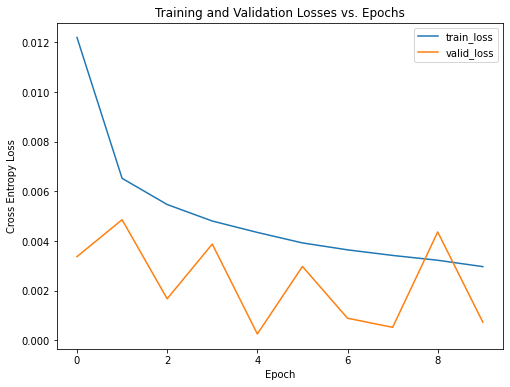

In [ ]:
plt.figure(figsize=(8,6))
for c in ['train_loss', 'valid_loss']:
  plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.title('Training and Validation Losses vs. Epochs')

Text(0.5, 1.0, 'Training and Validation Accuracies vs. Epochs')

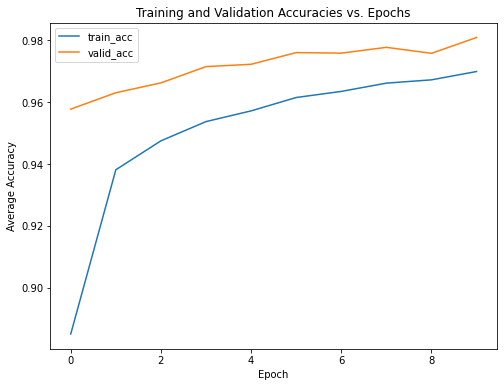

In [ ]:
plt.figure(figsize=(8,6))
for c in ['train_acc', 'valid_acc']:
  plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracies vs. Epochs')

#Generating predictions for the test dataset


##Showing how to reorder labels to be in the proper positions when using the contour method as it does not spit the images back in order

3
[2, 1, 0]


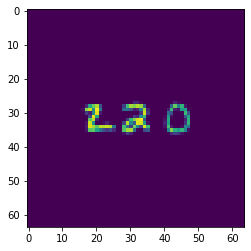

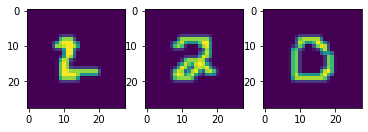

In [ ]:
#Code to look at specific images
segmentedPics, positions, sign = imageSegmentTest(test_data[10], [0,1,2,3,4])
print(str(len(segmentedPics)))
print(positions)
plt.imshow(test_data[10])
plt.show()

#Showing how to reorder everything since the segmentedpics function is not
#gauranteed to return in order
segmentedPics = reorder(segmentedPics, positions)

for i in range(len(segmentedPics)):
  plt.subplot(1,len(segmentedPics), i+1)
  plt.imshow(segmentedPics[i])

plt.show()

In [ ]:
#Function to reorder the images back into the correct order after image segment -- NO LONGER USED DUE TO SEGMENT UPDATE
def reorder(segmentedPics, positions):
  fixedOrder = []
  for i in range(len(segmentedPics)):
    fixedOrder.append(segmentedPics[positions.index(i)])
  
  return fixedOrder

##Make sure here to call model.eval() for testing after you load the model from the file path

In [ ]:
#This cell will generate the new test predicted labels

#Create copy of NN and load trained params/weights
testNet = Net()
testNet.load_state_dict(torch.load('best_model.pth'))
testNet.eval()

#Load onto GPU
testNet = testNet.to(device)

#We will now be working with testData - 1400 64x64 images
print(len(test_data))

new_labels = []
#Run through each image, segment it, convert it to tensor, and run it through the model
for i in range(len(test_data)):
  #Segment the pictures, reorder the output images to be in the order of the original image
  #Even though our test data has no labels we pass in [0,1,2,3,4] for use in the reordering
  #as imageSegmentTest does not necessarily return the digits in the same order as the 
  #they are original photo
  segmentedPics, positions, sign = imageSegmentTest(test_data[i], [0,1,2,3,4])
  segmentedPics = reorder(segmentedPics, positions)

  #Convert the images to tensors
  segmentedPics = (torch.as_tensor(segmentedPics)).unsqueeze(1)

  #Generate model predictions
  inputs = segmentedPics.float()
  inputs = inputs.to(device)
  
  outputs = testNet(inputs)
  _, predicted = torch.max(outputs.data, 1)

  #Bring data back to CPU
  predicted = predicted.cpu().numpy()

  #If we only had 4 digits then predicted will have length 4. We need to then append the 10 for missing digits since
  #label length must be 5  
  numMissingLabels = 5 - len(predicted)

  for j in range(numMissingLabels):
    predicted = np.append(predicted, 10)

  new_labels.append(predicted)

print(str(len(new_labels)))

14000
14000


In [ ]:
#Write the predicted labels to a csv file
with open('sample5.csv', mode='w') as csv_file:
  fieldnames = ['Id', 'Label']
  writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
  writer.writeheader()

  for i in range(len(new_labels)):
    stringLabel = ""+str(new_labels[i][0])+str(new_labels[i][1])+str(new_labels[i][2])+str(new_labels[i][3])+str(new_labels[i][4])
    stringId = str(i)
    writer.writerow({'Id': stringId, 'Label': stringLabel}) 

#Resources to Understand CNNs: 




https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627
https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8
https://web.stanford.edu/class/cs231m/projects/final-report-yang-pu.pdf
https://www.freecodecamp.org/news/an-intuitive-guide-to-convolutional-neural-networks-260c2de0a050/
https://towardsdatascience.com/convolution-neural-networks-a-beginners-guide-implementing-a-mnist-hand-written-digit-8aa60330d022

##Resources for Automatic Differentiation: 
https://github.com/jcjohnson/pytorch-examples

https://medium.com/@ODSC/automatic-differentiation-in-pytorch-6131b4581cdf

## Hyperparameter tuning:
https://deeplizard.com/learn/video/ycxulUVoNbk

https://medium.com/pytorch/accelerate-your-hyperparameter-optimization-with-pytorchs-ecosystem-tools-bc17001b9a49

## Example of CNN code with original MNIST dataset
https://nextjournal.com/gkoehler/pytorch-mnist

## Implementing basic model 

## IMPORTANT RESOURCES I FOUND THAT SPLIT THE IMAGE INTO 5 SEP IMAGES OF 1 DIGIT EACH: 
https://www.ijert.org/research/multi-digit-number-classification-using-mnist-and-ann-IJERTV9IS050330.pdf?fbclid=IwAR2_FHiFJDuBEhrDNSixdKysoD2ZAKJEHk4zeQ_bGo3QnVznENCSCfbZKEs

https://medium.com/@yash.kukreja.98/recognizing-handwritten-digits-in-real-life-images-using-cnn-3b48a9ae5e3
